# Import data

I am using a [dataset](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) from Kaggle that contains 80,000+ images of birds from 525 species. The objective is to build a model that is able to classify bird species from new images with a high accuracy.

The dataset is unbalanced, but each bird species has at least 130 images. The images are 224x224, with just one bird in the image taking up most of the image.

In [ ]:
# copy kaggle.json to Colab first

# download and unzip Kaggle dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download gpiosenka/100-bird-species
!unzip 100-bird-species.zip

# Split data

I'll split the data into training, validation, and test sets. Although the Kaggle dataset is already split into training, validation, and test sets, the splits given have images that are easier to classify in the validation and test sets. In order for the model to generalize better, I'll choose to use only the images from the training split in the Kaggle dataset.

From the 'train' folder, I'll split the images into 70% training, 20% validation, and 10% test. The training set will be used to fit the model, the validation set will be used to evaluate the models with different hyperparameters in order to select the best one, and the test set will only be used at the end to see how well the best model performs with data it has never seen before.

In [2]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [3]:
# load in data from only the train folder
data_dir = os.path.join('train')
img_size = (224, 224)
data = tf.keras.utils.image_dataset_from_directory(data_dir, seed = 20,
                                                   image_size = img_size)

Found 84635 files belonging to 525 classes.


In [4]:
# get labels for species
labels = data.class_names
num_classes = len(labels)

In [5]:
# split data into 70% training, 20% validation, 10% test
batches = len(data)

train_size = int(batches*.7)
val_size = int(batches*.2)
test_size = batches - (train_size + val_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Tune the hyperparameters of the CNN

Since there are a large number of classes, a more complex model is probably needed to achieve a high classification accuracy. In addition, such a model will require a large amount of resources, so I'll make use of transfer learning to help the training not be so computationally expensive.

The base model will be EfficientNetB0 trained on ImageNet. Then I'll add some number of dense layers on top of the neural network for further processing. Finally, the data goes through one last dense layer for classification. A dropout layer is also added between the dense layers to prevent overfitting. Whether a batch normalization layer can be added after a dense layer is another hyperparameter to be decided. The hyperparameters to be determined here are the number of dense layers besides the final one, the number of units for each dense layer, the dropout rate for each dropout layer, and whether a batch normalization layer is added after each dense layer except the last one.

Since the number of combinations of hyperparameters is large, I'll use Bayesian optimization to make informed decisions as to which set of hyperparameter values to try next.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import *

In [7]:
!pip install --upgrade keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.1 MB/s eta 0:00:00


In [8]:
import keras_tuner
import keras

In [9]:
# define the hypermodel
def build_model(hp):
    model = Sequential()

    efficient_net = EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False,
        pooling='max'
    )

    model.add(efficient_net)
    for layer in model.layers:
        layer.trainable = False

    num_dense_layers = hp.Choice('num_dense_layers', [1, 2, 3, 4, 5])
    for i in range(num_dense_layers):
        model.add(layers.Dense(hp.Choice(f'units{i+1}', [256, 512, 1024, 2048]),
                              activation='relu'))
        model.add(layers.Dropout(hp.Choice(f'dropout{i+1}',
                                [0.0, 0.1, 0.2, 0.3, 0.4])))
        if hp.Boolean(f'batch{i+1}'):
          model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',
                          tf.keras.metrics.SparseTopKCategoricalAccuracy()])
    return model

In [10]:
# set up the Bayesian optimization tuner
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective = 'val_accuracy',
    max_trials = 60,
    directory = 'drive/MyDrive/bird_tuner'
)

Reloading Tuner from drive/MyDrive/bird_tuner/untitled_project/tuner0.json


In [11]:
tuner.search(train, epochs=2, validation_data=val)
best_model = tuner.get_best_models()[0]

Trial 60 Complete [00h 02m 52s]
val_accuracy: 0.8447542786598206

Best val_accuracy So Far: 0.8830340504646301
Total elapsed time: 13h 15m 01s


In [12]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 525)               134925    
                                                                 
Total params: 4513456 (17.22 MB)
Trainable params: 46337

In [13]:
tuner.results_summary()

Results summary
Results in drive/MyDrive/bird_tuner/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 57 summary
Hyperparameters:
num_dense_layers: 1
units1: 256
dropout1: 0.1
batch1: True
units2: 512
dropout2: 0.2
batch2: False
units3: 2048
dropout3: 0.4
batch3: False
units4: 1024
dropout4: 0.0
batch4: True
units5: 256
dropout5: 0.2
batch5: True
Score: 0.8830340504646301

Trial 15 summary
Hyperparameters:
num_dense_layers: 1
units1: 512
dropout1: 0.0
batch1: True
units2: 1024
dropout2: 0.1
batch2: False
units3: 256
dropout3: 0.1
batch3: True
units4: 256
dropout4: 0.4
batch4: False
units5: 256
dropout5: 0.3
batch5: False
Score: 0.8719281554222107

Trial 58 summary
Hyperparameters:
num_dense_layers: 1
units1: 256
dropout1: 0.0
batch1: True
units2: 256
dropout2: 0.1
batch2: False
units3: 256
dropout3: 0.2
batch3: True
units4: 256
dropout4: 0.0
batch4: False
units5: 256
dropout5: 0.4
batch5: True
Score: 0.8718100190162659

Trial 33 summary
Hype

# Train the first model

In this section, I grab the best model according to the Bayesian optimization tuner and train it further. Early stopping is implemented to stop the model from training if its performance is not improving anymore.

In [17]:
# grab the best model from the tuner
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model(best_hp)

In [18]:
# train model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit(train, epochs=50, validation_data = val, callbacks = [callback])

Epoch 1/50
1851/1851 [==============================] - 87s 43ms/step - loss: 1.5578 - accuracy: 0.7038 - sparse_top_k_categorical_accuracy: 0.8633 - val_loss: 0.5970 - val_accuracy: 0.8566 - val_sparse_top_k_categorical_accuracy: 0.9642
Epoch 2/50
1851/1851 [==============================] - 78s 42ms/step - loss: 0.5499 - accuracy: 0.8649 - sparse_top_k_categorical_accuracy: 0.9688 - val_loss: 0.5905 - val_accuracy: 0.8508 - val_sparse_top_k_categorical_accuracy: 0.9624
Epoch 3/50
1851/1851 [==============================] - 82s 44ms/step - loss: 0.4687 - accuracy: 0.8772 - sparse_top_k_categorical_accuracy: 0.9755 - val_loss: 0.4913 - val_accuracy: 0.8738 - val_sparse_top_k_categorical_accuracy: 0.9700
Epoch 4/50
1851/1851 [==============================] - 78s 42ms/step - loss: 0.4221 - accuracy: 0.8876 - sparse_top_k_categorical_accuracy: 0.9792 - val_loss: 0.4661 - val_accuracy: 0.8813 - val_sparse_top_k_categorical_accuracy: 0.9734
Epoch 5/50
1851/1851 [==========================

In [19]:
# save model
model.save("drive/MyDrive/bird_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


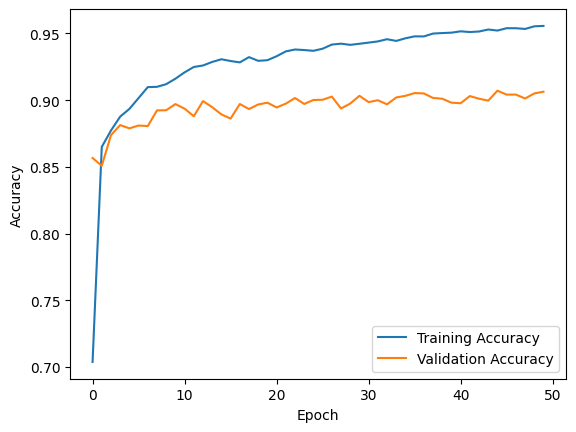

In [21]:
# plot accuracy by epoch
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Further tune the model

The top 5 models found by Bayesian optimization all use only one dense layer besides the top layer and batch optimization. I'll now use a grid search to tune the number of units in that dense layer and the dropout rate.

The training accuracy is higher than the validation accuracy and is steadily increasing in the best model found by Bayesian optimization. This is a sign of overfitting. Some regularization should be considered.

In [26]:
def build_model(hp):
    model = Sequential()

    efficient_net = EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False,
        pooling='max'
    )

    model.add(efficient_net)
    for layer in model.layers:
        layer.trainable = False


    model.add(layers.Dense(hp.Choice('units', [256, 512, 1024, 2048]),
                          activation='relu'))
    model.add(layers.Dropout(hp.Choice('dropout',
                            [0.0, 0.1, 0.2, 0.3, 0.4])))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',
                          tf.keras.metrics.SparseTopKCategoricalAccuracy()])
    return model

In [27]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective = 'val_accuracy',
    directory = 'drive/MyDrive/bird_tuner',
    project_name = '1layer'
)

In [28]:
tuner.search(train, epochs=4, validation_data=val)
best_model = tuner.get_best_models()[0]

Trial 20 Complete [00h 05m 28s]
val_accuracy: 0.8657253980636597

Best val_accuracy So Far: 0.8861649632453918
Total elapsed time: 01h 50m 06s


In [31]:
tuner.oracle.get_best_trials(20)[0].hyperparameters.values

{'units': 512, 'dropout': 0.2}

In [32]:
tuner.oracle.get_best_trials(20)[0].score

0.8861649632453918

In [33]:
tuner_results = tuner.oracle.get_best_trials(20)

In [38]:
tuner_data = [trial.hyperparameters.values for trial in tuner_results]
for i in range(len(tuner_data)):
    tuner_data[i]['score'] = tuner_results[i].score

In [47]:
import pandas as pd
tuner_df = pd.DataFrame(tuner_data)
tuner_df = tuner_df.pivot(index='dropout', columns='units', values='score')
tuner_df.head()

units,256,512,1024,2048
dropout,,,,
0.0,0.875886,0.876536,0.866493,0.868797
0.1,0.877186,0.882798,0.874882,0.879549
0.2,0.872105,0.886165,0.881853,0.881793
0.3,0.876122,0.879017,0.877363,0.874705
0.4,0.873700,0.870392,0.880907,0.865725


<Axes: xlabel='units', ylabel='dropout'>

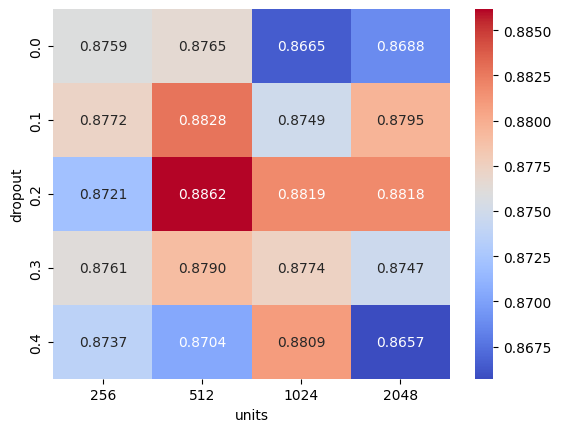

In [54]:
# visualize the validation accuracy of each model from the grid search
import seaborn as sns
sns.heatmap(tuner_df, annot=True, cmap='coolwarm', fmt='.4f')

# Regularization

As mentioned before, there is evidence of overfitting so I'll attempt to combat this with kernel regularization in the dense layer. I'll train the model with the best validation accuracy from the previous tuning but I'll add in a kernel regularization in the dense layer with parameter $\lambda$ being different orders of magnitude.

In [11]:
from tensorflow.keras.regularizers import l2

def reg_model(lam):
    model = Sequential()

    efficient_net = EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False,
        pooling='max'
    )

    model.add(efficient_net)
    for layer in model.layers:
        layer.trainable = False


    model.add(layers.Dense(512, activation='relu',
                          kernel_regularizer=l2(lam)))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',
                          tf.keras.metrics.SparseTopKCategoricalAccuracy()])
    return model

In [13]:
for i in range(3):
    print(f'Training model with lambda = {10**(-i-2)}')
    reg_model(10**(-i-2)).fit(train, epochs=4, validation_data=val)

Training model with lambda = 0.01
Epoch 1/4
1851/1851 [==============================] - 104s 48ms/step - loss: 3.3095 - accuracy: 0.5781 - sparse_top_k_categorical_accuracy: 0.8091 - val_loss: 2.5404 - val_accuracy: 0.5560 - val_sparse_top_k_categorical_accuracy: 0.8181
Epoch 2/4
1851/1851 [==============================] - 86s 46ms/step - loss: 2.0085 - accuracy: 0.6699 - sparse_top_k_categorical_accuracy: 0.8890 - val_loss: 1.7439 - val_accuracy: 0.7306 - val_sparse_top_k_categorical_accuracy: 0.9200
Epoch 3/4
1851/1851 [==============================] - 86s 46ms/step - loss: 1.9974 - accuracy: 0.6451 - sparse_top_k_categorical_accuracy: 0.8768 - val_loss: 1.5298 - val_accuracy: 0.7625 - val_sparse_top_k_categorical_accuracy: 0.9305
Epoch 4/4
1851/1851 [==============================] - 82s 44ms/step - loss: 1.9537 - accuracy: 0.6398 - sparse_top_k_categorical_accuracy: 0.8724 - val_loss: 1.5852 - val_accuracy: 0.7332 - val_sparse_top_k_categorical_accuracy: 0.9151
Training model wi

# Training a second model

It looks like the l2 kernel regularization with $\lambda = 0.0001$ is a promising model. I'll further train this model.

In [15]:
model = reg_model(10**(-4))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit(train, epochs=20, validation_data = val, callbacks = [callback])

Epoch 1/20
1851/1851 [==============================] - 96s 48ms/step - loss: 1.6436 - accuracy: 0.6932 - sparse_top_k_categorical_accuracy: 0.8634 - val_loss: 0.8701 - val_accuracy: 0.8129 - val_sparse_top_k_categorical_accuracy: 0.9509
Epoch 2/20
1851/1851 [==============================] - 84s 45ms/step - loss: 0.8277 - accuracy: 0.8248 - sparse_top_k_categorical_accuracy: 0.9552 - val_loss: 0.7422 - val_accuracy: 0.8451 - val_sparse_top_k_categorical_accuracy: 0.9631
Epoch 3/20
1851/1851 [==============================] - 88s 48ms/step - loss: 0.7515 - accuracy: 0.8380 - sparse_top_k_categorical_accuracy: 0.9628 - val_loss: 0.6571 - val_accuracy: 0.8686 - val_sparse_top_k_categorical_accuracy: 0.9681
Epoch 4/20
1851/1851 [==============================] - 83s 45ms/step - loss: 0.7029 - accuracy: 0.8475 - sparse_top_k_categorical_accuracy: 0.9668 - val_loss: 0.6882 - val_accuracy: 0.8544 - val_sparse_top_k_categorical_accuracy: 0.9659
Epoch 5/20
1851/1851 [==========================

# Train a third model

From the hyperparameter search for $\lambda$ in the kernel regularization, it does not seem like regularization improves the performance of the model. Therefore, I want to further train the model without any kernel regularization.

In [18]:
model = Sequential()

efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False,
    pooling='max'
)

model.add(efficient_net)
for layer in model.layers:
    layer.trainable = False


model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy',
                      tf.keras.metrics.SparseTopKCategoricalAccuracy()])

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit(train, epochs=20, validation_data = val, callbacks = [callback])

Epoch 1/20
1851/1851 [==============================] - 90s 45ms/step - loss: 1.5541 - accuracy: 0.6923 - sparse_top_k_categorical_accuracy: 0.8640 - val_loss: 0.6578 - val_accuracy: 0.8475 - val_sparse_top_k_categorical_accuracy: 0.9597
Epoch 2/20
1851/1851 [==============================] - 82s 44ms/step - loss: 0.6944 - accuracy: 0.8297 - sparse_top_k_categorical_accuracy: 0.9579 - val_loss: 0.7348 - val_accuracy: 0.8238 - val_sparse_top_k_categorical_accuracy: 0.9491
Epoch 3/20
1851/1851 [==============================] - 81s 44ms/step - loss: 0.5990 - accuracy: 0.8450 - sparse_top_k_categorical_accuracy: 0.9645 - val_loss: 0.4995 - val_accuracy: 0.8763 - val_sparse_top_k_categorical_accuracy: 0.9709
Epoch 4/20
1851/1851 [==============================] - 81s 44ms/step - loss: 0.5262 - accuracy: 0.8604 - sparse_top_k_categorical_accuracy: 0.9708 - val_loss: 0.4716 - val_accuracy: 0.8816 - val_sparse_top_k_categorical_accuracy: 0.9709
Epoch 5/20
1851/1851 [==========================

In [21]:
model.save('bird_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


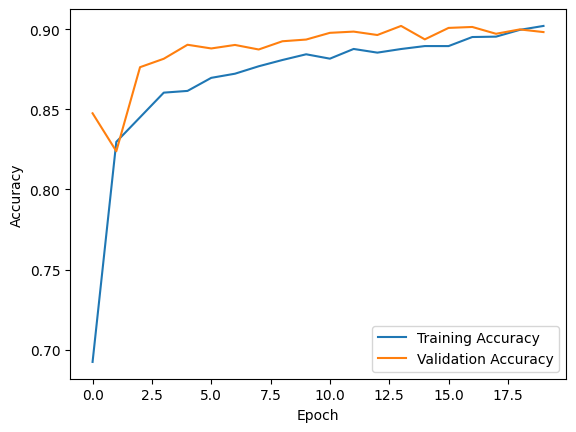

In [63]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate third model on the test set

Since the validation accuracy is the best for the third model, I want to evaluate it by having it make predictions on the test set.

In [ ]:
# load model
model = tf.keras.models.load_model("bird_classifier.h5")

In [64]:
model.evaluate(test)

265/265 [==============================] - 20s 29ms/step - loss: 0.4241 - accuracy: 0.8973 - sparse_top_k_categorical_accuracy: 0.9745


[0.4240989685058594, 0.8973451256752014, 0.9745132923126221]

This model gives a test accuracy of 89.73% and a top 5 accuracy of 97.45%.